## 电解槽预测性维护

* 需求定义-通过建立预测性维护模型，实现对电解槽设备的在线监控，对故障进行提前预警，预见性的采取维护措施，降低系统宕机风险
* 数据采集-工业现场DCS系统通过OPC接口，基于OPC-UA将数据远程接入数据中心
* 数据预处理-多维度数据清洗，缺失值处理，异常值处理，重采样
* 特征工程-基于物理特性，构造特征和特征降维（LSTM略去该步骤）
* 模型建立-
* 模型筛选-评价指标建立，按不平衡样本分类问题评估，包含Precision, Recall, F1, auc, ROC, BIC
* 在线运维-模型在线维护

### 数据清洗

In [1]:
#from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import os
import sys

In [2]:
# 原始数据采集与清洗
filepath = 'D:/新增鼎统计建模部/专利/预测性维护/maintance prediction/maintance prediction'
datafile = 'data_record.csv'
datapath = os.path.join(filepath,datafile)
rawdata = pd.read_csv(datapath)

rawdata.head(2)

,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,max_p,record
0,-0.152057,-0.791192,0.398970,-0.895885,0.183239,0.520263,1.0,1
1,0.007417,-1.026115,1.312138,-0.960858,-0.586150,0.634078,1.0,1


In [3]:
print(rawdata.dtypes)

df = rawdata

#Remove the duplicated rows
df = df.drop_duplicates()

#remove rows with missing
df = df.dropna(how='any')

Comp.1    float64
Comp.2    float64
Comp.3    float64
Comp.4    float64
Comp.5    float64
Comp.6    float64
max_p     float64
record      int64
dtype: object


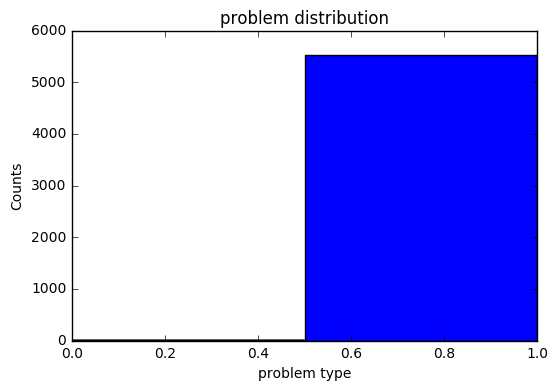

异常概率:
0.0007228044813877846
Wall time: 2.76 s


In [4]:
%%time
import matplotlib.pyplot as plt
#show histogram distribution of some features
ax1 = df['record'].plot(kind='hist',bins=2,facecolor='blue')
ax1.set_title('problem distribution')
ax1.set_xlabel('problem type'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4));plt.suptitle('');plt.show()
print('异常概率:')
print(np.float(df[df['record']==0].record.count())/np.float(df.record.count()))

In [5]:
str(np.float(df[df['record']==0].record.count())/np.float(df.record.count()))

'0.0007228044813877846'

In [6]:
%%time
import seaborn as sns
#show correlation matrix heatmap to explore some potential interesting patterns
corr = df.corr()
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)

Wall time: 5.31 s


### 特征工程

#### LSTM 参数服务器

In [7]:
import tensorflow as tf

In [8]:
lr = 1e-3 
batch_size = tf.placeholder(tf.int32)

#输入变量维度
input_size = 7

#时序持续窗口长度为 7
timestep_size = 7

#隐含层的节点数
hidden_size = 128

#LSTM layer层数
layer_num = 2

#输出分类类别数量，如果是回归预测的话应该是1
class_num = 1

#输入变量的占位
_X = tf.placeholder(tf.float32, [None,input_size * timestep_size])
#输出变量的占位
y = tf.placeholder(tf.float32, [None, class_num])
#保留概率
keep_prob = tf.placeholder(tf.float32)


#### LSTM模型构建主体

In [9]:
import tensorflow as tf
from tensorflow.contrib import rnn

In [10]:
#Step1. Input reshaping

#RNN input shape = [batch_size, timestep_size, input_size]
X = tf.reshape(_X, [-1,timestep_size,input_size])

#Step2. LSTM_cell definition
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=hidden_size,forget_bias=1.0,state_is_tuple=True)

#Step3. Add dropout layer, set output_keep_prob
lstm_cell = tf.nn.rnn_cell.DropoutWrapper(cell=lstm_cell,output_keep_prob=keep_prob)

#Step4. Use MultiRNNCell to realize the multilayer RNN !!!!!ERROR
mlstm_cell = tf.nn.rnn_cell.MultiRNNCell(cells=[lstm_cell] * layer_num,state_is_tuple=True)

#Step5. initialize all the state
init_state = lstm_cell.zero_state(batch_size,dtype=tf.float32)

#Step6. Run the network， dynamic_rnn ( batch,steps,inputs) as X_in
outputs,final_state = tf.nn.dynamic_rnn(lstm_cell,inputs=X,initial_state=init_state,time_major=False)

#Step7. Ouput config
W = tf.Variable(tf.truncated_normal([hidden_size,class_num],stddev=0.1),dtype=tf.float32)
bias = tf.Variable(tf.constant(0.1, shape=[class_num,]),dtype=tf.float32)
y_pre = tf.nn.softmax(tf.matmul(final_state[1],W) + bias)


In [11]:
#Step 8. loss/cost function
cost = tf.nn.softmax_cross_entropy_with_logits(logits=y_pre,labels=y)
cross_entropy = tf.reduce_mean(cost)

#Step 9. train_op 
train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

#Step 10. Evaluation metrics
correct_prediction = tf.equal(tf.argmax(y_pre,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [12]:
#Step 10. Summary Definition

#Define the scalar 
tf.summary.scalar('cross_entropy',cross_entropy)
tf.summary.scalar('accuracy',accuracy)

#Define summury op
merged_summary_op = tf.summary.merge_all()


In [15]:
try_name = 'record'
trx_names = df.columns - [try_name]
trx = df[trx_names].values
tr_y = df[try_name].values

# Start the session
training_iters = 1000
_batch_size = 20
with tf.Session() as sess:
    #Generate the writer
    summary_writer = tf.summary.FileWriter('C:/Users/Xiangdong KONG/Documents/Python Scripts/PySpark-Predictive-Maintenance-master/tmp/logdir',sess.graph)
    sess.run(tf.global_variables_initializer())
    step = 0
    #while (step * _batch_size < training_iters):
    for i in range(30):
        #try:
        training_batch = zip(range(0, len(trx)-5*timestep_size,timestep_size),
                            range(timestep_size,len(trx)-4*timestep_size, timestep_size))
        for start, end in training_batch:
            batch_xs = np.array([trx[start+i:end+i] for i in range(_batch_size)]).reshape([_batch_size,timestep_size*input_size])
            batch_ys = tr_y[end:_batch_size+end].reshape([-1,1])
            sess.run(train_op, feed_dict={_X:batch_xs,y:batch_ys,keep_prob:1.0,batch_size:_batch_size})
            if step % 20 == 0:
                summary_str, ac = sess.run([merged_summary_op,accuracy],feed_dict={_X:batch_xs,y:batch_ys, keep_prob:1.0,batch_size:_batch_size}) 
                print(summary_str)
                summary_writer.add_summary(summary_str,step)
                print('step %d, accuracy %g' %(step, ac))
                

            step += 1
                

C:\Users\Xiangdong KONG\Anaconda2\envs\py3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  from ipykernel import kernelapp as app


b'\n\x14\n\rcross_entropy\x15\x00\x00\x00\x00\n\x0f\n\x08accuracy\x15\x00\x00\x80?'
step 0, accuracy 1
b'\n\x14\n\rcross_entropy\x15\x00\x00\x00\x00\n\x0f\n\x08accuracy\x15\x00\x00\x80?'
step 20, accuracy 1
b'\n\x14\n\rcross_entropy\x15\x00\x00\x00\x00\n\x0f\n\x08accuracy\x15\x00\x00\x80?'
step 40, accuracy 1
b'\n\x14\n\rcross_entropy\x15\x00\x00\x00\x00\n\x0f\n\x08accuracy\x15\x00\x00\x80?'
step 60, accuracy 1
b'\n\x14\n\rcross_entropy\x15\x00\x00\x00\x00\n\x0f\n\x08accuracy\x15\x00\x00\x80?'
step 80, accuracy 1
b'\n\x14\n\rcross_entropy\x15\x00\x00\x00\x00\n\x0f\n\x08accuracy\x15\x00\x00\x80?'
step 100, accuracy 1
b'\n\x14\n\rcross_entropy\x15\x00\x00\x00\x00\n\x0f\n\x08accuracy\x15\x00\x00\x80?'
step 120, accuracy 1
b'\n\x14\n\rcross_entropy\x15\x00\x00\x00\x00\n\x0f\n\x08accuracy\x15\x00\x00\x80?'
step 140, accuracy 1
b'\n\x14\n\rcross_entropy\x15\x00\x00\x00\x00\n\x0f\n\x08accuracy\x15\x00\x00\x80?'
step 160, accuracy 1
b'\n\x14\n\rcross_entropy\x15\x00\x00\x00\x00\n\x0f\n\x08accu

In [14]:
        except:
            print('failed session')
            step += 1
            continue
            
    

SyntaxError: invalid syntax (<ipython-input-14-34a1f2c4c646>, line 1)

In [ ]:
np.shape(batch_xs)

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
len(trx)

In [ ]:
end